# KNN Classification with Pretrained Model Features

Credit: https://github.com/UMBCvision/CompRess/blob/master/eval_knn.py

### Import Libraries

In [69]:
import torch
import faiss
import os.path
import numpy as np
from random import shuffle
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from timm import create_model
from tqdm.auto import tqdm
from helpers.ImageFolderPathsIndices import get_dataloader

### Classify feature with K-nearest neighbor search

In [70]:
# Note: k is the number of neighboring points to consider
def knn(feats_train, labels_train, feats_val, k):
    feats_train = feats_train.numpy()
    labels_train = labels_train.numpy()
    feats_val = feats_val.numpy()

    # use feature vector dimensionality
    index = faiss.IndexFlatL2(feats_train.shape[-1])
    index.add(feats_train)
    # perform KNN search
    D, I = index.search(feats_val, k)

    pred = np.zeros(I.shape[0])
    for i in range(I.shape[0]):
        # list of (label, # of votes)
        votes = list(Counter(labels_train[I[i]]).items())
        # Randomly shuffle in case votes are tied
        shuffle(votes)
        # Note: this works for any number of class in the labels
        # choose the label (idx 0) with the max votes (idx 1)
        pred[i] = max(votes, key=lambda x: x[1])[0]
    # return numpy array of predictions for each validation image
    return pred

### Generate features from pretrained model

In [71]:
def get_features(dataloader, model, device):
    # set up feature extractor for inference
    model.eval()
    model.to(device)

    features, labels, indices, ptr = None, None, None, 0

    # Assuming data is on cpu
    with torch.no_grad():
        for cur_indices, cur_images, cur_labels, _ in tqdm(dataloader):
            cur_images = cur_images.to(device)
            cur_features = model(cur_images).to("cpu")

            B, D = cur_features.shape
            # get indices in current batch
            inds = ptr + torch.arange(B)

            if not ptr:
                features = torch.zeros((len(dataloader.dataset), D)).float()
                labels = torch.zeros(len(dataloader.dataset)).long()
                indices = torch.zeros(len(dataloader.dataset)).long()
            
            features.index_copy_(0, inds, cur_features)
            labels.index_copy_(0, inds, cur_labels)
            indices.index_copy_(0, inds, cur_indices)
            ptr += B
    return features, labels, indices

### Features + KNN inference

In [72]:
def inference_pipeline(dataset_folder, model_name, k):
    traindata = get_dataloader(dataset_folder, 32, 'train', train_aug=False, normalize="ImageNet")
    testdata = get_dataloader(dataset_folder, 32, 'test', train_aug=False, normalize="ImageNet")
    model = create_model(model_name, pretrained=True, num_classes=0)

    if not os.path.exists('features'):
        os.mkdir('features')
        
    cached_feats = f'features/{model_name}_train.pth.tar'
    if os.path.exists(cached_feats):
        train_features, train_labels, train_indices = torch.load(cached_feats)
        print("Loaded train features from file.")
    else:
        train_features, train_labels, train_indices = get_features(traindata, model, 'mps')
        torch.save((train_features, train_labels, train_indices), cached_feats)
        print("Saved train features to file.")

    cached_feats = f'features/{model_name}_test.pth.tar'
    if os.path.exists(cached_feats):
        test_features, test_labels, test_indices = torch.load(cached_feats)
        print("Loaded test feature from file.")
    else:
        test_features, test_labels, test_indices = get_features(testdata, model, 'mps')
        torch.save((test_features, test_labels, test_indices), cached_feats)
        print("Saved test features to file.")
    
    test_pred = np.zeros(test_labels.shape[0])

    # run k-NN 10 times and ensemble results
    for i in range(10):
        test_pred += knn(train_features, train_labels, test_features, k)
    test_pred /= 5
    test_pred[test_pred >= 0.5] = 1
    test_pred[test_pred < 0.5] = 0

    print(f"Accuracy: {accuracy_score(test_labels, test_pred):%}")
    cm = confusion_matrix(test_labels.numpy(), test_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["active", "inactive"])
    disp.plot()

## Test Performance

### ResNet50

  0%|          | 0/48 [00:00<?, ?it/s]

Saved train features to file.


  0%|          | 0/7 [00:00<?, ?it/s]

Saved test features to file.
Accuracy: 81.500000%


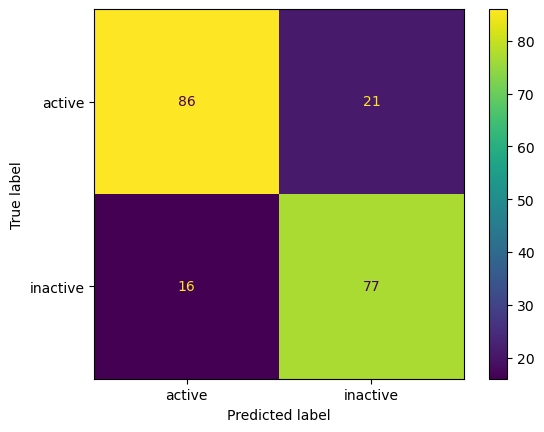

In [73]:
inference_pipeline('SC-2000v2', 'resnet50d', 30)

### MobileNetv2_100

  0%|          | 0/48 [00:00<?, ?it/s]

Saved train features to file.


  0%|          | 0/7 [00:00<?, ?it/s]

Saved test features to file.
Accuracy: 83.500000%


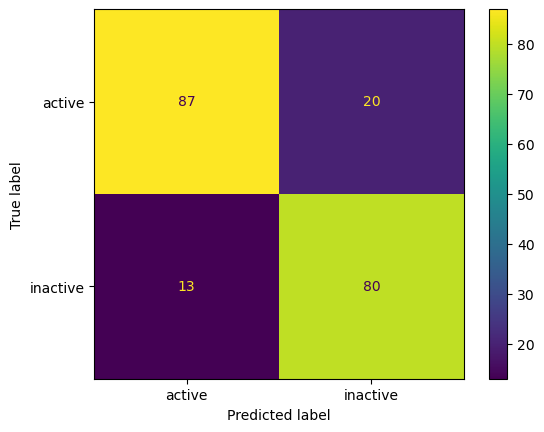

In [74]:
inference_pipeline('SC-2000v2', 'mobilenetv2_100', 50)

### DenseNet121

Loaded train features from file.
Loaded test feature from file.
Accuracy: 81.500000%


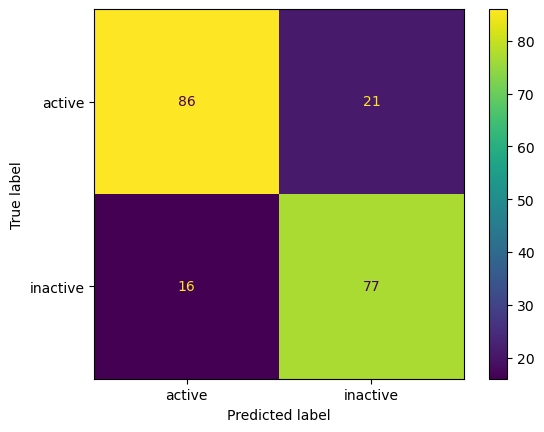

In [76]:
inference_pipeline('SC-2000v2', 'densenet121', 50)